# Downloading packages

We will be using [Segmentation Models Pytorch](https://github.com/qubvel/segmentation_models.pytorch), a library widely used for semantic segmentation that provided popular models such as the UNet and is built on the Pytorch Framework.

In [ ]:
!pip install -q segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 60.2 MB/s eta 0:00:00


We will be using [Weights & Biases](https://wandb.ai/site) to monitor our training and validation which simplifies the process of visualizing the whole training process for repeated trial and errors to get the best hyperparameters for our experiments.

In [ ]:
!pip install wandb --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00


In [ ]:
!pip install hvplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 4.5 MB/s eta 0:00:00


In [ ]:
!pip install colorama

# Import Libraries

In [ ]:
import os
import gc
import copy
import time
import pandas as pd
import numpy as np
import glob
import random
from tqdm import tqdm
from collections import defaultdict
from IPython import display as ipd
from termcolor import colored
import hvplot.pandas

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.cuda import amp
import torch.optim as optim
from torch.optim import Adam
from torch.optim import lr_scheduler
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
# from torch.utils.tensorboard import SummaryWriter

import segmentation_models_pytorch as smp
import timm

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, StratifiedGroupKFold
import wandb

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

This part is used for logging in our individual wandb account using `kaggle_secrets`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read the WandB API key from the file
with open('/content/drive/MyDrive/wandb.txt', 'r') as f:
    api_key = f.readline().strip()

# Set the environment variable for WandB
os.environ["WANDB_API_KEY"] = api_key

# Login to WandB
import wandb
wandb.login()

wandb: Currently logged in as: mahdiiut079 (mi79). Use `wandb login --relogin` to force relogin


True

# Configuration Parameters

These are some of the parameters that we might change during the experiments. It's better to keep everything in a single place.

In [ ]:
class CFG:
    seed                   = 42
    exp_name               = 'EfficientNet-B2'
    comment                = 'unet-efficientnet-b2-224x224-split2'
    model_name             = 'Unet'
    backbone               = 'efficientnet-b2'
    decoder_attention_type = 'scse'
    train_bs               = 8
    valid_bs               = 50
    img_size               = [224, 224]
    epochs                 = 50
    lr                     = 1e-4
    scheduler              = 'CosineAnnealingLR'
    min_lr                 = 1e-6
    T_mult                 = 2
    T_max                  = 10
    T_0                    = 15
    warmup_epochs          = 0
    wd                     = 1e-6
    n_accumulate           = max(1, 32//train_bs)
    n_fold                 = 5
    num_classes            = 1
    device                 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     aux_params        = {'classes':1, 'pooling':'avg', 'dropout':0.5, 'activation':None}

# Reproducibility

We will ensure reproducibility by providing a single seed for all the random tasks

In [ ]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')

set_seed(CFG.seed)

> SEEDING DONE


# Dataset loading & preprocessing

As our dataset is in an Image Folder structure. We will convert it to a dataframe for efficiently using the image and mask files and also including labels for each sample explicitly so that we can use it later.

In [ ]:
# Directory containing files
directory = '/content/drive/MyDrive/DL+ML+AIA Project/EBHI-SEG'

# Create a DataFrame containing file paths for images and masks
df = pd.DataFrame(columns=['image_files', 'mask_files'])
cancer_types = ['Normal', 'Polyp', 'Low-grade IN', 'Adenocarcinoma', 'High-grade IN', 'Serrated adenoma']
label2id = {'Normal': 0, 'Polyp':1, 'Low-grade IN':2, 'Adenocarcinoma':3, 'High-grade IN':4, 'Serrated adenoma':5}
id2label = {0: 'Normal', 1: 'Polyp', 2: 'Low-grade IN', 3: 'Adenocarcinoma', 4: 'High-grade IN', 5: 'Serrated adenoma'}

for cancer_type in cancer_types:
    image_dir = os.path.join(directory, cancer_type, 'image')
    mask_dir = os.path.join(directory, cancer_type, 'label')

    # Check if the image and mask directories exist
    if not os.path.exists(image_dir) or not os.path.exists(mask_dir):
        print(f"Directory not found for {cancer_type}. Skipping...")
        continue

    image_files = sorted(os.listdir(image_dir))

    for file in image_files:
        image_file = os.path.join(image_dir, file)
        mask_file = os.path.join(mask_dir, file.replace('.jpg', '_mask.jpg'))  # Assuming mask file name is derived from image file name

        # Check if mask file exists
        if os.path.isfile(mask_file):
            df = pd.concat([df, pd.DataFrame({'image_files': [image_file], 'mask_files': [mask_file]})], ignore_index=True)


# Print the length of the DataFrame
print("Total number of samples:", len(df))


Total number of samples: 2226


In [ ]:
# print(df['image_files'][1387])
# print(df['image_files'][1290])

In [ ]:
def label_image(img_path):
    for cancer_type in cancer_types:
        if cancer_type in img_path:
            return cancer_type

df['label names'] = df['image_files'].copy().map(label_image)

In [ ]:
def label_image_num(img_path):
    for label, cancer_type in enumerate(cancer_types):
        if cancer_type in img_path:
            return label

df['label'] = df['image_files'].copy().map(label_image_num)

In [ ]:
zlen(df[df['label names']=='Low-grade IN'])
len(df[df['label']==2])

637

In [ ]:
df.sample(10).hvplot.table(columns=['image_files', 'mask_files', 'label names', 'label'])

:Table   [image_files,mask_files,label names,label]

#### As we can see the label, label names, masks and images are consistent. So we have successfully made out dataframe object.

#### Since we will be using RGB images we want to obtain the individual channel mean values to normalize the images.

In [ ]:
# Initialize sums and pixel count
mean_sums = np.array([0.0, 0.0, 0.0])
std_sums = np.array([0.0, 0.0, 0.0])
num_pixels = 0

# Process each image
for path in df['image_files']:
    image = Image.open(path)
    image_np = np.array(image) / 255.0  # Convert to 0-1 range if needed
#     num_pixels += image_np.shape[0] * image_np.shape[1]
    mean_sums += image_np.mean(axis=(0, 1))  # Mean over height and width
    std_sums += image_np.std(axis=(0, 1))  # Std deviation over height and width

# Calculate mean and std dev for each channel
mean_channels = mean_sums / len(df)
std_channels = std_sums / len(df)

print("Mean per channel:", mean_channels)
print("Standard deviation per channel:", std_channels)

Mean per channel: [0.519624   0.34783007 0.68143765]
Standard deviation per channel: [0.22924705 0.24072345 0.14470555]


# Visualization utils

In [ ]:
def plot_fig(df, label_name, nrows=3,ncols=9):

    '''
    Plots the first nrows*ncols number of images for a single class

    Args

    df: The dataframe object
    label_name: The name of the particular label that we want to see.
    nrows: number of images in each row
    ncols: number of images in each column

    Returns

    A grid of nrows*ncolumns images
    '''

    fig,ax = plt.subplots(nrows, ncols, figsize=(27,9))
    plt.subplots_adjust(wspace=0, hspace=0)
    label_files = df[df['label names']==label_name]['image_files']

    for idx, img_path in enumerate(label_files.tolist()[:nrows*ncols]):
        img = Image.open(img_path)
#         idcol.rectangle(((0,0),(95,95)),outline='white')

        # Show the binary segmented image using Matplotlib
        plt.subplot(nrows, ncols, idx+1)
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(f"{label_name}", y=0.94)

In [ ]:
def plot_masks(df, label_name, nrows=3,ncols=9):

    '''
    Plots the first nrows*ncols number of masks for a single class

    Args

    df: The dataframe object
    label_name: The name of the particular label that we want to see.
    nrows: number of images in each row
    ncols: number of images in each column

    Returns

    A grid of nrows*ncolumns masks
    '''

    fig,ax = plt.subplots(nrows, ncols, figsize=(27,9))
    plt.subplots_adjust(wspace=0, hspace=0)
    label_files = df[df['label names']==label_name]['mask_files']

    for idx, img_path in enumerate(label_files.tolist()[:nrows*ncols]):
        img = Image.open(img_path)
#         idcol.rectangle(((0,0),(95,95)),outline='white')
        plt.subplot(nrows, ncols, idx+1)
        plt.imshow(np.array(img), cmap='gray')
        plt.axis('off')

    plt.suptitle(f"{label_name}", y=0.94)

In [ ]:
plot_fig(df, "Normal")

Output hidden; open in https://colab.research.google.com to view.

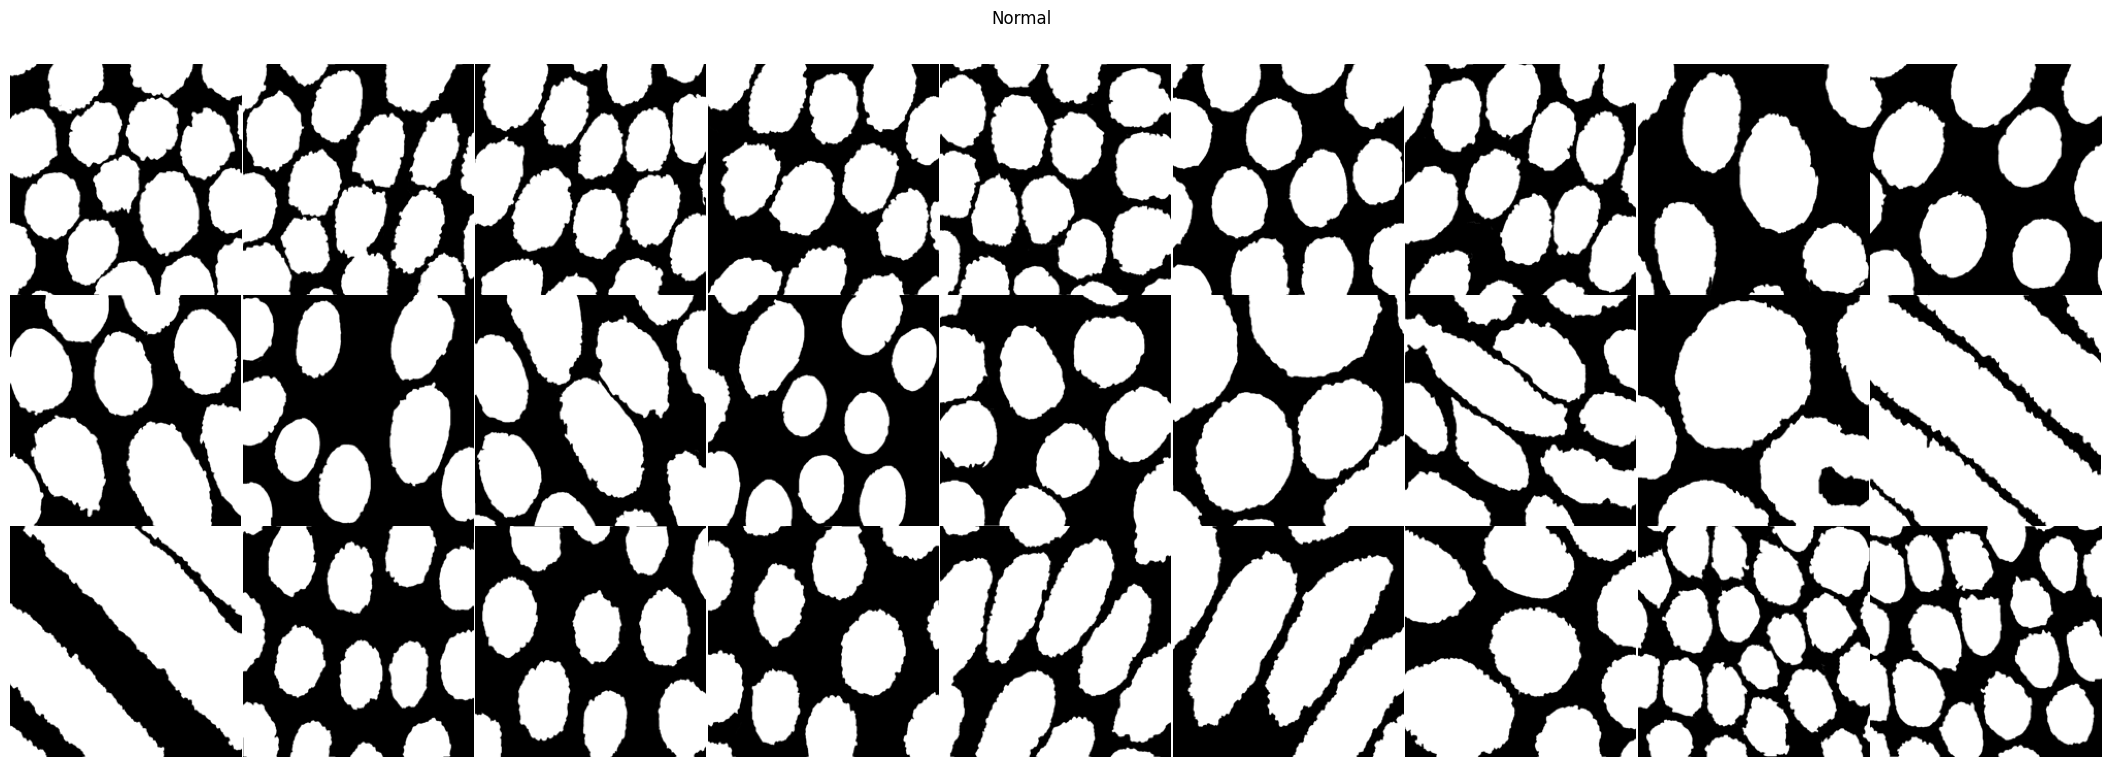

In [ ]:
plot_masks(df, "Normal")

In [ ]:
# Transpose the image and mask to have channels first
image = cv2.imread(df['image_files'][0])
mask = cv2.imread(df['mask_files'][0])
image_T = image.transpose()
mask_T = mask.transpose()
print(image_T.shape)
print(mask_T.shape)

(3, 224, 224)
(3, 224, 224)


In [ ]:
image_PIL = Image.open(df['image_files'][500])
mask_PIL = Image.open(df['mask_files'][500])

In [ ]:
np.unique(np.array(mask_PIL))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 18

(array([12905.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 37271.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

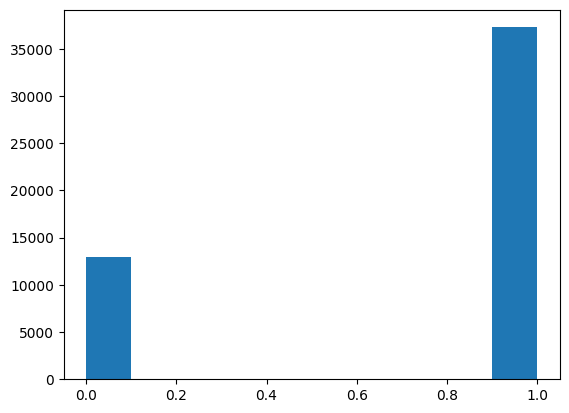

In [ ]:
plt.hist((np.array(mask_PIL)/255).astype(int).reshape(-1))

As we can see there are some other values aside from 0 and 255 in the mask which should not exist in a binary mask. So we should do some thresholding to make it binary. Otherwise it might decrease our performance during training.

(-0.5, 223.5, 223.5, -0.5)

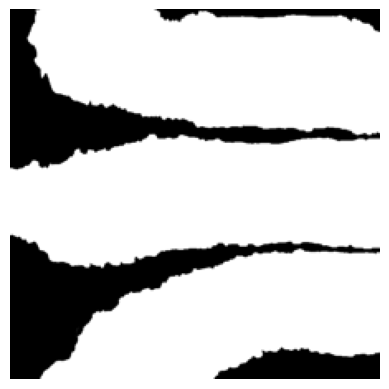

In [ ]:
plt.imshow(np.array(mask_PIL), cmap='gray')
plt.axis('off')

# Create Folds

We will divide the Dataset into three parts. `test_df` will be kept for inference and `df_train` will be used for train and validation. Dataset will be divided into ****70 : 15 : 15**** ratio for train, validation and test. We will use Stratified CV since there is an imbalance in labels.

In [ ]:
# Split the dataset into train and validation sets (85:15)
df_train, test_df = train_test_split(df, test_size=0.15, random_state=CFG.seed, shuffle=True, stratify=df['label names'])

In [ ]:
df_train = df_train.reset_index()

In [ ]:
# Initialize StratifiedKFold with the specified number of splits and random state
skf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)

# Create stratified folds and assign fold numbers to the validation indices
for fold, (train_idx, val_idx) in enumerate(skf.split(df_train, df_train['label names'])):
    # Assign the fold number to the validation indices
    df_train.loc[val_idx, 'fold'] = fold

# Display the distribution of images per fold and label
display(df_train.groupby(['fold', 'label names'])['image_files'].count())

fold  label names     
0.0   Adenocarcinoma      136
      High-grade IN        32
      Low-grade IN        108
      Normal               13
      Polyp                80
      Serrated adenoma     10
1.0   Adenocarcinoma      135
      High-grade IN        32
      Low-grade IN        108
      Normal               13
      Polyp                81
      Serrated adenoma     10
2.0   Adenocarcinoma      135
      High-grade IN        32
      Low-grade IN        108
      Normal               13
      Polyp                81
      Serrated adenoma      9
3.0   Adenocarcinoma      135
      High-grade IN        31
      Low-grade IN        108
      Normal               13
      Polyp                81
      Serrated adenoma     10
4.0   Adenocarcinoma      135
      High-grade IN        31
      Low-grade IN        109
      Normal               13
      Polyp                80
      Serrated adenoma     10
Name: image_files, dtype: int64

# Creating Dataset Object

Here we are making two separate dataset objects for making the original dataset and the augmented dataset. We are doing this because we want to increase the size of our dataset using data augmentation. We also want to ensure the data imbalance doesn't increase more because of it. So we will do the following.

- Make a custom sampler which gives more weights to minority classes.
- The augmentation. pipeline will randomly pick a number of images using that sampling technique and then will do the augmentation on those images and then add them to the main dataset.

In [ ]:
def add_gaussian_noise(image, stddev=0.1):
    noise = torch.randn_like(image) * stddev
    return image + noise

def train_image_transforms():
    return v2.Compose([
        v2.ToImage(),  # Convert input to image format
        v2.ToDtype(torch.float32, scale=True), # Convert image to float32 and scale
        v2.Normalize(mean=[0.519624, 0.34783007, 0.68143765], std=[0.22924705, 0.24072345, 0.14470555])
    ])

def train_image_transforms_with_augmentation():
    return v2.Compose([
        v2.ToImage(),  # Convert input to image format
        v2.ToDtype(torch.float32, scale=True), # Convert image to float32 and scale
    ])

def mask_transforms():
    return v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Lambda(lambda x: torch.where(x > 0.5, torch.tensor(1.), torch.tensor(0.)))  # Thresholding operation
    ])

def valid_transforms():
    return v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.519624, 0.34783007, 0.68143765], std=[0.22924705, 0.24072345, 0.14470555])
    ])


In [ ]:
class WSI_Dataset(Dataset):
    def __init__(self, dataframe, train=True, augmentation=True):
        self.data = dataframe
        self.train = train
        self.labels = self.data['label'].tolist()  # Store labels for easy access

        if train:
            if augmentation:
                self.image_transform = train_image_transforms_with_augmentation()
                self.mask_transform = mask_transforms()

            else:
                self.image_transform = train_image_transforms()
                self.mask_transform = mask_transforms()
        else:
            self.image_transform = valid_transforms()
            self.mask_transform = mask_transforms()  # Keep the transforms ready even for validation

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = row['image_files']
        image = Image.open(image_path).convert("RGB")
        label = row['label']

        # Check if the mask path exists and is not NaN
        mask = None
        if 'mask_files' in row and pd.notna(row['mask_files']):
            mask_path = row['mask_files']
            mask = Image.open(mask_path).convert("L")  # Convert to grayscale mask

        # Apply the image transformation
        if self.image_transform:
            image = self.image_transform(image)

        # Apply the mask transformation if mask is loaded
        if mask is not None and self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask, label


In [ ]:
def make_weights_for_balanced_classes(dataframe, nclasses):
    count = [0] * nclasses
    for item in dataframe['label']:  # Assuming the label column is named 'label'
        count[item] += 1

    weight_per_class = [0.] * nclasses
    N = float(sum(count))
    for i in range(nclasses):
        weight_per_class[i] = N / float(count[i])

    total_weight = sum(weight_per_class)
    normalized_weight_per_class = [w / total_weight for w in weight_per_class]

    weight = [0] * len(dataframe)
    for idx, val in enumerate(dataframe['label']):
        weight[idx] = normalized_weight_per_class[val]

    return weight

In [ ]:
class RandomAugmentation:
    def __init__(self):
        self.transforms = [
            v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
            v2.GaussianBlur(kernel_size=(3, 7), sigma=(0.1, 3.)),
            v2.RandomAdjustSharpness(sharpness_factor=2),
            v2.Lambda(add_gaussian_noise)
        ]

    def __call__(self, img):
        num_transforms = random.randint(1, len(self.transforms))
        selected_transforms = random.sample(self.transforms, num_transforms)
        transform = v2.Compose(selected_transforms+[v2.Normalize(mean=[0.519624, 0.34783007, 0.68143765], std=[0.22924705, 0.24072345, 0.14470555])]  # Normalize the image
                              )
        return transform(img)

In [ ]:
class Augmented_WSI_Dataset(Dataset):
    def __init__(self, original_dataset, num_augmented_images, num_copies=2):
        self.original_dataset = original_dataset
        self.num_augmented_images = num_augmented_images
        self.num_copies = num_copies

        self.original_images = list(range(len(self.original_dataset)))
        self.augmented_images = random.sample(self.original_images, self.num_augmented_images)
        self.total_images = len(self.original_dataset) + (self.num_augmented_images * self.num_copies)

        self.augmentation_transform = RandomAugmentation()

        # Get labels of augmented images
        labels = [self.original_dataset[idx][2] for idx in self.augmented_images]
        df_aug = pd.DataFrame({'label': labels})
        self.weights = make_weights_for_balanced_classes(df_aug, nclasses=len(set(labels)))
        self.sampler = WeightedRandomSampler(self.weights, num_samples=len(self.weights), replacement=True)

    def __len__(self):
        return self.total_images

    def __getitem__(self, idx):
        if idx < len(self.original_dataset):
            image, mask, label = self.original_dataset[idx]
        else:
            aug_idx = next(iter(self.sampler))
            img_idx = self.augmented_images[aug_idx // self.num_copies]
            image, mask, label = self.original_dataset[img_idx]
            if self.augmentation_transform:
                image = self.augmentation_transform(image)

        return image, mask, label


# Create Dataloaders

In [ ]:
def prepare_loaders(fold, num_augmented_images=1200, num_copies=2, augmentation=True):
    train_df = df_train.query("fold!=@fold").reset_index(drop=True)
    valid_df = df_train.query("fold==@fold").reset_index(drop=True)

    if augmentation:
        # Create the original and augmented datasets
        original_train_dataset = WSI_Dataset(train_df, train=True)
        augmented_train_dataset = Augmented_WSI_Dataset(original_train_dataset, num_augmented_images, num_copies)

        # Use DataLoader for the augmented dataset
        train_loader = DataLoader(augmented_train_dataset, batch_size=CFG.train_bs,
                                  shuffle=True, pin_memory=True, drop_last=False)

        valid_dataset = WSI_Dataset(valid_df, train=False)
        valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs,
                                  shuffle=False, pin_memory=True)

        return train_loader, valid_loader

    else:
        # Create the original and augmented datasets
        original_train_dataset = WSI_Dataset(train_df, train=True, augmentation=augmentation)

        # Use DataLoader for the augmented dataset
        train_loader = DataLoader(original_train_dataset, batch_size=CFG.train_bs,
                                  shuffle=True, pin_memory=True, drop_last=False)

        valid_dataset = WSI_Dataset(valid_df, train=False)
        valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs,
                                  shuffle=False, pin_memory=True)

        return train_loader, valid_loader


In [ ]:
train_loader, valid_loader = prepare_loaders(fold=0, num_augmented_images=1200, num_copies=2, augmentation=False)

In [ ]:
len(train_loader)

190

In [ ]:
# Verifying dataloaders work
for images, masks, labels in train_loader:
    print(f'Training batch - Images shape: {images.shape}, Masks shape: {masks.shape}, Labels shape: {labels.shape}')
    break
for images, masks, labels in valid_loader:
    print(f"Validation batch - Images shape: {images.shape}, Masks shape: {masks.shape}, Labels shape: {labels.shape}")
    break

Training batch - Images shape: torch.Size([8, 3, 224, 224]), Masks shape: torch.Size([8, 1, 224, 224]), Labels shape: torch.Size([8])
Validation batch - Images shape: torch.Size([50, 3, 224, 224]), Masks shape: torch.Size([50, 1, 224, 224]), Labels shape: torch.Size([50])


In [ ]:
images[0]

tensor([[[-1.9416, -1.7877, -2.1640,  ..., -0.6758, -0.6073, -0.9837],
         [-1.7364, -1.7364, -2.0443,  ...,  0.0598,  0.1453, -0.4705],
         [-1.5995, -1.6679, -2.0272,  ..., -0.0086,  0.3164, -0.7613],
         ...,
         [ 0.2480,  1.1888,  0.7783,  ..., -1.8048, -1.2574, -1.3600],
         [ 0.1624,  0.9151, -0.7100,  ..., -1.6679, -0.9837, -0.8639],
         [-1.0863, -0.8468, -1.7364,  ..., -1.7193, -1.3258, -1.2916]],

        [[-1.2657, -1.2983, -1.4286,  ..., -0.4349, -0.3209, -0.4838],
         [-1.2494, -1.3146, -1.4286,  ...,  0.1027,  0.2004, -0.2231],
         [-1.2169, -1.2332, -1.4286,  ..., -0.0113,  0.4285, -0.3860],
         ...,
         [ 0.3308,  0.9009,  0.5425,  ..., -1.3472, -0.9888, -0.9725],
         [ 0.3470,  0.8032, -0.4349,  ..., -1.2494, -0.8096, -0.6304],
         [-0.5978, -0.5652, -1.1680,  ..., -1.2332, -0.9562, -0.8911]],

        [[-3.2186, -2.9747, -3.2999,  ..., -1.4571, -1.4029, -2.1346],
         [-2.2972, -2.2430, -2.6224,  ...,  0

In [ ]:
id2label = {0: 'Normal', 1: 'Polyp', 2: 'Low-grade IN', 3: 'Adenocarcinoma', 4: 'High-grade IN', 5: 'Serrated adenoma'}

# Define your mean and std values used for normalization
mean = np.array([0.519624, 0.34783007, 0.68143765])
std = np.array([0.22924705, 0.24072345, 0.14470555])

def denormalize(image, mean, std):
    """
    Denormalizes an image with the given mean and std.

    Args:
    image (numpy.ndarray): The normalized image.
    mean (list): The mean used for normalization for each channel.
    std (list): The standard deviation used for normalization for each channel.

    Returns:
    numpy.ndarray: The denormalized image.
    """
    image = image * std + mean  # Apply denormalization
    image = np.clip(image, 0, 1)  # Clip values to be between 0 and 1
    return (image * 255).astype(np.uint8)  # Scale to 0-255 and convert to uint8

# Iterate over batches
for batch in train_loader:
    images, masks, labels = batch

    # Convert tensors to numpy arrays
    images = images.numpy()
    masks = masks.numpy().astype('uint8')
    labels = labels.numpy()

    # Reshape images from (batch_size, channels, height, width) to (batch_size, height, width, channels)
    images = np.transpose(images, (0, 2, 3, 1))
    masks = np.transpose(masks, (0, 2, 3, 1))

    # Denormalize the images
    denorm_images = np.array([denormalize(img, mean, std) for img in images])

    # Plot sample images and masks
    fig, axes = plt.subplots(nrows=len(images), ncols=3, figsize=(16, 48))
    for i in range(len(images)):
        label_name = id2label[labels[i]]
        axes[i, 0].imshow(denorm_images[i])
        axes[i, 0].set_title(f' Cancer Type: {label_name}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(images[i])
        axes[i, 1].set_title(f'Normalized Version')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(masks[i], cmap='gray')
        axes[i, 2].set_title('Mask')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()
    break  # Only visualize the first batch

Output hidden; open in https://colab.research.google.com to view.

# The UNet Architecture
     
[UNet](https://arxiv.org/abs/1505.04597) is a deep learning neural network architecture originally designed for image segmentation tasks, but has since found use in GANs and latent diffusion models. Similar to autoencoders, the UNet structures include an encoder for compressing the input into a lower dimensional representation and a decoder for reconstructing the output from this compressed form. However, UNet distinguishes itself from autoencoders with several features:

- **Bottleneck**: At the centre of UNet is the bottleneck layer, situated between the encoder and decoder. This component captures the most abstract representation of the input.

- **Symmetrical Design**: The encoder and decoder parts of UNet are mirror images of each other. This symmetry facilitates the implementation of skip connections, which directly connect layers of the encoder to their corresponding layers in the decoder.

- **Skip Connections**: Unlike conventional autoencoders, UNet incorporates skip connections that can bypass the bottleneck, directly connecting the encoder to the decoder. These connections transfer contextual information from the spatially rich encoder, to the more feature heavy decoder, aiding in the precise localisation necessary for detailed segmentation.

In this project we're going to try different backbones for Unet including EfficientNet, VGG16, ResNet. We will also use UNet with attention and UNet++.

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png"
     align="right"
     width="1000"
     style="padding: 20px;" />

In [ ]:
def build_model():
    model = smp.Unet(
        encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        decoder_use_batchnorm=True,
        # decoder_attention_type=CFG.decoder_attention_type,
        activation=None,
#         aux_params=CFG.aux_params
    )
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [ ]:
# class EncoderBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
#         super().__init__()
#         expansion_ratio = 4

#         self.encoder_block = nn.Sequential(
#             # ConvNeXt style blocks
#             nn.Conv2d(in_channels,                   in_channels, kernel_size=(7,7), stride=1, padding=3, groups=in_channels),
#             nn.BatchNorm2d(in_channels),
#             nn.Conv2d(in_channels,  expansion_ratio*out_channels, kernel_size=(1,1), stride=1),
#             activation,
#             nn.Conv2d(expansion_ratio*out_channels, out_channels, kernel_size=(1,1), stride=1),

#             nn.Conv2d(out_channels,                 out_channels, kernel_size=(7,7), stride=1, padding=3, groups=out_channels),
#             nn.BatchNorm2d(out_channels),
#             nn.Conv2d(out_channels, expansion_ratio*out_channels, kernel_size=(1,1), stride=1),
#             activation,
#             nn.Conv2d(expansion_ratio*out_channels, out_channels, kernel_size=(1,1), stride=1),
#         )
#     def forward(self, x):
#         return self.encoder_block(x)


# class DecoderBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
#         super().__init__()
#         expansion_ratio = 4

#         self.decoder_block = nn.Sequential(
#             nn.Conv2d(in_channels,                    in_channels, kernel_size=(7,7), stride=1, padding=3, groups=in_channels),
#             nn.BatchNorm2d(in_channels),
#             nn.Conv2d(in_channels,    expansion_ratio*in_channels, kernel_size=(1,1), stride=1),
#             activation,
#             nn.Conv2d(expansion_ratio*in_channels,   out_channels, kernel_size=(1,1), stride=1),

#             nn.Conv2d(out_channels,                  out_channels, kernel_size=(7,7), stride=1, padding=3, groups=out_channels),
#             nn.BatchNorm2d(out_channels),
#             nn.Conv2d(out_channels,  expansion_ratio*out_channels, kernel_size=(1,1), stride=1),
#             activation,
#             nn.Conv2d(expansion_ratio*out_channels,  out_channels, kernel_size=(1,1), stride=1),
#         )
#     def forward(self, x):
#         return self.decoder_block(x)


# class UNet2(nn.Module):
#     def __init__(self):
#         super().__init__()

#         # Config
#         in_channels  = 4   # Input images have 4 channels
#         out_channels = 3   # Mask has 3 channels
#         n_filters    = 32  # Scaled down from 64 in original paper
#         activation   = nn.ReLU()

#         # Up and downsampling methods
#         self.downsample  = nn.MaxPool2d((2,2), stride=2)
#         self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)

#         # Encoder
#         self.enc_block_1 = EncoderBlock(in_channels, 1*n_filters, activation)
#         self.enc_block_2 = EncoderBlock(1*n_filters, 2*n_filters, activation)
#         self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters, activation)
#         self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters, activation)

#         # Bottleneck
#         self.bottleneck = nn.Sequential(
#             nn.Conv2d(     8*n_filters,   8*n_filters, kernel_size=(7,7), stride=1, padding=3, groups=8*n_filters),
#             nn.BatchNorm2d(8*n_filters),
#             nn.Conv2d(     8*n_filters, 4*8*n_filters, kernel_size=(1,1), stride=1),
#             activation,
#             nn.Conv2d(   4*8*n_filters,   8*n_filters, kernel_size=(1,1), stride=1),

#             nn.Conv2d(     8*n_filters,   8*n_filters, kernel_size=(7,7), stride=1, padding=3, groups=8*n_filters),
#             nn.BatchNorm2d(8*n_filters),
#             nn.Conv2d(     8*n_filters, 4*8*n_filters, kernel_size=(1,1), stride=1),
#             activation,
#             nn.Conv2d(   4*8*n_filters,   8*n_filters, kernel_size=(1,1), stride=1),
#         )

#         # Decoder
#         self.dec_block_4 = DecoderBlock(8*n_filters, 4*n_filters, activation)
#         self.dec_block_3 = DecoderBlock(4*n_filters, 2*n_filters, activation)
#         self.dec_block_2 = DecoderBlock(2*n_filters, 1*n_filters, activation)
#         self.dec_block_1 = DecoderBlock(1*n_filters, 1*n_filters, activation)

#         # Output projection
#         self.output      = nn.Conv2d(1*n_filters,  out_channels, kernel_size=(1,1), stride=1, padding=0)

#     def forward(self, x):
#         # Encoder
#         skip_1 = self.enc_block_1(x)
#         x      = self.downsample(skip_1)
#         skip_2 = self.enc_block_2(x)
#         x      = self.downsample(skip_2)
#         skip_3 = self.enc_block_3(x)
#         x      = self.downsample(skip_3)
#         skip_4 = self.enc_block_4(x)
#         x      = self.downsample(skip_4)

#         # Bottleneck
#         x      = self.bottleneck(x)

#         # Decoder
#         x      = self.upsample(x)
#         x      = torch.add(x, skip_4)  # Skip connection
#         x      = self.dec_block_4(x)
#         x      = self.upsample(x)
#         x      = torch.add(x, skip_3)  # Skip connection
#         x      = self.dec_block_3(x)
#         x      = self.upsample(x)
#         x      = torch.add(x, skip_2)  # Skip connection
#         x      = self.dec_block_2(x)
#         x      = self.upsample(x)
#         x      = torch.add(x, skip_1)  # Skip connection
#         x      = self.dec_block_1(x)
#         x      = self.output(x)
#         return x

# Evaluation Metrics and Loss Function
For this task we are using `DiceLossImb` a modified `dice_loss` as our loss function. This particular implementation modifies the standard dice loss by incorporating squared terms in the denominator, which can help in situations with imbalanced classes.

In [ ]:
class DiceLossImb(nn.Module):
    def __init__(self, smooth=1e-3):
        super(DiceLossImb, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Ensure the sigmoid activation is applied to inputs if not included in model
        inputs = torch.sigmoid(inputs)

        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Intersection is the sum of multiplied inputs and targets
        intersection = (inputs * targets).sum()

        # Calculate the Dice score with squared terms in the denominator
        dice_score = (2. * intersection + self.smooth) / (inputs.pow(2).sum() + targets.pow(2).sum() + self.smooth)

        # Dice loss is 1 minus the Dice score
        return 1 - dice_score

In [ ]:
# JaccardLoss = smp.losses.JaccardLoss(mode='binary')
# # DiceLoss    = smp.losses.DiceLoss(mode='binary')
# # BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
# BCELoss     = nn.BCEWithLogitsLoss()
# LovaszLoss  = smp.losses.LovaszLoss(mode='binary', per_image=False)
# TverskyLoss = smp.losses.TverskyLoss(mode='binary', log_loss=False)

DiceLoss = DiceLossImb()

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    intersection = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*intersection+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    intersection = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((intersection + epsilon) / (union + epsilon)).mean()  # Add epsilon to avoid division by zero
    return iou

def criterion(y_true, y_pred):
#     return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)

# Building blocks for training

The following code outlines the training function for our UNet models, leveraging efficient techniques like mixed precision to enhance performance and resource utilization.

#### Training Process:

- Setup:
    - Initialize the UNet model and move it to the specified device (GPU or CPU).
    - Configure the Adam optimizer for parameter updates and use the Dice loss function to handle segmentation tasks and class imbalances.
    - Optionally, employ a learning rate scheduler to adjust the learning rate dynamically during training.
    
    
- Epoch Loop: Iterate through each epoch, performing both training and validation steps:

- Training Phase:
    - Set the model to training mode, enabling features like dropout and batch normalization to function correctly.
    - For each batch from the DataLoader:
        - Move inputs and masks to the chosen device.
        - Apply mixed precision (using AMP) to perform the forward pass and compute the loss, reducing memory usage and speeding up computation.
        - Backpropagate the loss to compute gradients and update model parameters using the optimizer.
        - Zero the gradients post-update to prepare for the next batch.
        - Optionally, adjust the learning rate with the scheduler after each batch.
        
        
- Validation Phase:
    - Switch the model to evaluation mode to ensure consistent behavior of layers like dropout and batch normalization.
    - Evaluate the model on a separate validation set without updating model parameters to monitor its generalization performance.
    - Calculate the validation loss to track the model's performance on unseen data.
    
    
- Progress Tracking:
    - Throughout the epoch, the function tracks cumulative training loss and updates the progress bar with the current epoch's loss, learning rate, and GPU memory usage.
    
    - After each epoch, it prints the average training and validation losses, offering insights into the model's learning and generalization capabilities.


- Output:
    - The function returns lists of average training and validation losses for each epoch, useful for further analysis and visualization to assess the model’s progress over time.
This approach ensures efficient and effective training of the UNet model, making it particularly suitable for large-scale segmentation tasks where performance and stability are critical.

# Train function

In [ ]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()

    dataset_size = 0
    running_loss = 0.0

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (inputs, masks, _) in pbar:
        inputs, masks = inputs.to(device, dtype=torch.float), masks.to(device, dtype=torch.float)

        batch_size = inputs.size(0)

        with amp.autocast(enabled=True):
            outputs = model(inputs)
            loss   = DiceLoss(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        if scheduler is not None:
            scheduler.step()

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss

# Validation function

In [ ]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()

    dataset_size = 0
    running_loss = 0.0

    val_scores = []

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (inputs, masks, _) in pbar:
        inputs, masks  = inputs.to(device, dtype=torch.float), masks.to(device, dtype=torch.float)

        batch_size = inputs.size(0)

        outputs = model(inputs)
        loss = DiceLoss(outputs, masks)

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        y_pred = nn.Sigmoid()(outputs)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])

        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss, val_scores


In [ ]:
class EarlyStopping:
    """Early stops the training if validation Dice score doesn't improve after a given patience."""

    def __init__(self, patience=7, delta=0, path="checkpoint.pth", trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation Dice score improved.
                            Default: 7
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pth'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_dice_min = -np.Inf  # Since we are looking for maximum Dice score
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_dice, model):
        score = val_dice  # We use Dice score directly

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_dice, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
            self.save_checkpoint(val_dice, model)

    def save_checkpoint(self, val_dice, model):
        """Saves model when validation Dice score increases."""
        improvement_message = f"Validation Dice score improved ({self.val_dice_min:.6f} --> {val_dice:.6f}).  Saving model ..."
        self.trace_func(colored(improvement_message, 'green'))
        torch.save(model.state_dict(), self.path)
        self.val_dice_min = val_dice

In [ ]:
def run_training(model, optimizer, device, num_epochs, train_loader, valid_loader):
    wandb.watch(model, log_freq=100)

    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))

    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice = -np.Inf
    best_epoch = -1
    best_val_loss = np.inf
    history = defaultdict(list)
    early_stopping = EarlyStopping(patience=7, delta=0.0001, path='checkpoint.pth', trace_func=print)

    scheduler = fetch_scheduler(optimizer)

    val_losses = []

    # Initialize the best model path
    best_model_path = None

    for epoch in range(1, num_epochs + 1):
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')

        train_loss = train_one_epoch(model, optimizer, scheduler,
                                     dataloader=train_loader,
                                     device=device, epoch=epoch)

        val_loss, val_scores = valid_one_epoch(model, valid_loader,
                                               device=device,
                                               epoch=epoch)

        val_dice, val_jaccard = val_scores

        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)


        current_lr = scheduler.get_last_lr()[0]

        wandb.log({"Train Loss": train_loss,
                   "Valid Loss": val_loss,
                   "Valid Dice": val_dice,
                   "Valid Jaccard": val_jaccard,
                   "LR": current_lr})

        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        val_losses.append(val_loss)

        early_stopping(val_dice, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        if val_dice > best_dice:
            print(f"Valid Dice Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
            best_dice = val_dice
            best_jaccard = val_jaccard
            best_epoch = epoch

            # Save the best model based on validation loss to ensure consistency with early stopping
            best_model_path  = f"best_model-{fold:02d}.bin"
            torch.save(model.state_dict(), best_model_path )
            wandb.save(best_model_path)
            print(f"Best Model Saved for epoch {epoch}")

            run.summary["Best Dice"] = best_dice
            run.summary["Best Jaccard"] = best_jaccard
            run.summary["Best Epoch"] = best_epoch


        if epoch == num_epochs:
            last_model_wts = copy.deepcopy(model.state_dict())
            last_model_path = "last_epoch.bin"
            torch.save(model.state_dict(), last_model_path)
            print("Last Epoch Model Saved")

        print(); print()

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))

    # Load the best model weights based on validation loss
    model.load_state_dict(best_model_wts)

    history['Best Dice'] = best_dice
    history['Best Jaccard'] = best_jaccard
    history['Best Epoch'] = best_epoch

    return model, history


# Optimizer

In [ ]:
def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max,
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0,
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None

    return scheduler

In [ ]:
# model = UNet().to(CFG.device)
model = build_model()
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)

# Training

In [ ]:
best_overall_dice = -np.inf
best_overall_model_wts = None

for fold in range(3):
    print(f'#'*15)
    print(f'### Fold: {fold}')
    print(f'#'*15)
    run = wandb.init(project='cct-seg-unicas',
                     config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},
                     anonymous=anonymous,
#                      name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}|attention-{CFG.decoder_attention_type}|batch_norm-True|batchsize-8|augmentation-weighted_sampling",
                       name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}|batch_norm-True|batchsize-8",
                     group=CFG.comment,
                    )
    train_loader, valid_loader = prepare_loaders(fold=fold, num_augmented_images=500, num_copies=2, augmentation=True)
    model = build_model()
    optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)

    model, history = run_training(model, optimizer,
                                  device=CFG.device,
                                  num_epochs=50,
                                  train_loader=train_loader,
                                  valid_loader=valid_loader)

    # Update overall best model
    if history['Best Dice'] > best_overall_dice:
        best_overall_dice = history['Best Dice']
        best_overall_model_wts = copy.deepcopy(model.state_dict())

    run.finish()
    display(ipd.IFrame(run.url, width=1000, height=720))

# Save the best overall model weights
if best_overall_model_wts is not None:
    torch.save(best_overall_model_wts, f"best_model_overall.bin")
    print(f"Best overall model saved with dice score: {best_overall_dice:.4f}")
else:
    print("No best model weights to save.")

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

<!-- ### Upgraded UNet

This vanilla Unet is a smaller version of the original [U-Net](https://arxiv.org/abs/1505.04597) paper. But rather than increasing the parameters let's apply some advanced CV tweaks to improve the performance.

#### Separable convolution layers
Popularised by Chollet in [Xception](https://arxiv.org/abs/1610.02357), we're going to use separable convolution layers rather than conventional convolution layers.

#### Batch normalisation
Batch norm has become a staple inclusion in most convnet architectures.

#### Larger kernel sizes
[ConvNeXt](https://arxiv.org/abs/2201.03545) found that using larger kernel sizes of (7x7) outperformed (3x3) kernels in their experiments. We'll adopt this change.

#### Inverse bottlenecks
From [MobileNetV2](https://arxiv.org/abs/1801.04381), we're going to use inverse bottlenecks after our depthwise convolution, to improve the parameter efficiency in our model.

#### Additive skip connections
Rather than using a `concat skip connection`, we'll use an `additive skip connection` one. This change reduces the number of parameters as well and should give the model a clearer residual signal.

#### Learning rate decay
A standard inclusion to help more powerful models refine their predictions. -->